In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os

from utils import *

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "contrastive_fns" 
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True

In [4]:
exp_names = [
    "ant_l_ipo_ef_l2",
    "ant_l_dpo_ef_l2",
    "ant_l_sppo_ef_l2",
    "ant_l_fb_ef_l2",
    "ant_l_flatnce_backward_ef_l2",
    "ant_l_binary_ef_l2",
    "ant_l_infonce_ef_l2",
    "ant_l_infonce_backward_ef_l2",
    "ant_l_flatnce_ef_l2",
    "ant_l_symmetric_infonce_ef_l2",
]

exp_names_mapping = {
    "ant_l_ipo_ef_l2": "IPO",
    "ant_l_dpo_ef_l2": "DPO",
    "ant_l_sppo_ef_l2": "SPPO",
    "ant_l_fb_ef_l2": "Forward-Backward",
    "ant_l_flatnce_backward_ef_l2": "FlatNCE Backward",
    "ant_l_flatnce_ef_l2": "FlatNCE",
    "ant_l_infonce_ef_l2": "InfoNCE",
    "ant_l_infonce_backward_ef_l2": "InfoNCE Backward",
    "ant_l_symmetric_infonce_ef_l2": "Symmetric InfoNCE",
    "ant_l_binary_ef_l2": "Binary",
}


In [5]:
env_title_mapping = {
    "ant_ball": "Ant Soccer",
    "ant": "Ant",
    "ant_big_maze": "Ant Big Maze",
    "ant_u_maze": "Ant U-Maze",
    "pusher_hard": "Pusher"
}
metric_to_metric_label_dict = {
    "eval/episode_success": "Time near goal",
    "eval/episode_success_any": "Success rate",
}

# Results for all envs

In [6]:
metrics_ = ["eval/episode_success_any", "eval/episode_success"]
single_env=False


In [7]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [8]:
len(runs)

500

IPO, Ant Soccer
(10, 1, 50)
DPO, Ant Soccer
(10, 1, 50)
SPPO, Ant Soccer
(10, 1, 50)
Forward-Backward, Ant Soccer
(10, 1, 50)
FlatNCE Backward, Ant Soccer
(10, 1, 50)
FlatNCE, Ant Soccer
(10, 1, 50)
InfoNCE, Ant Soccer
(10, 1, 50)
InfoNCE Backward, Ant Soccer
(10, 1, 50)
Symmetric InfoNCE, Ant Soccer
(10, 1, 50)
Binary, Ant Soccer
(10, 1, 50)
IPO, Ant
(10, 1, 50)
DPO, Ant
(10, 1, 50)
SPPO, Ant
(10, 1, 50)
Forward-Backward, Ant
(10, 1, 50)
FlatNCE Backward, Ant
(10, 1, 50)
FlatNCE, Ant
(10, 1, 50)
InfoNCE, Ant
(10, 1, 50)
InfoNCE Backward, Ant
(10, 1, 50)
Symmetric InfoNCE, Ant
(10, 1, 50)
Binary, Ant
(10, 1, 50)
IPO, Ant Big Maze
(10, 1, 50)
DPO, Ant Big Maze
(10, 1, 50)
SPPO, Ant Big Maze
(10, 1, 50)
Forward-Backward, Ant Big Maze
(10, 1, 50)
FlatNCE Backward, Ant Big Maze
(10, 1, 50)
FlatNCE, Ant Big Maze
(10, 1, 50)
InfoNCE, Ant Big Maze
(10, 1, 50)
InfoNCE Backward, Ant Big Maze
(10, 1, 50)
Symmetric InfoNCE, Ant Big Maze
(10, 1, 50)
Binary, Ant Big Maze
(10, 1, 50)
IPO, Ant U-Maze

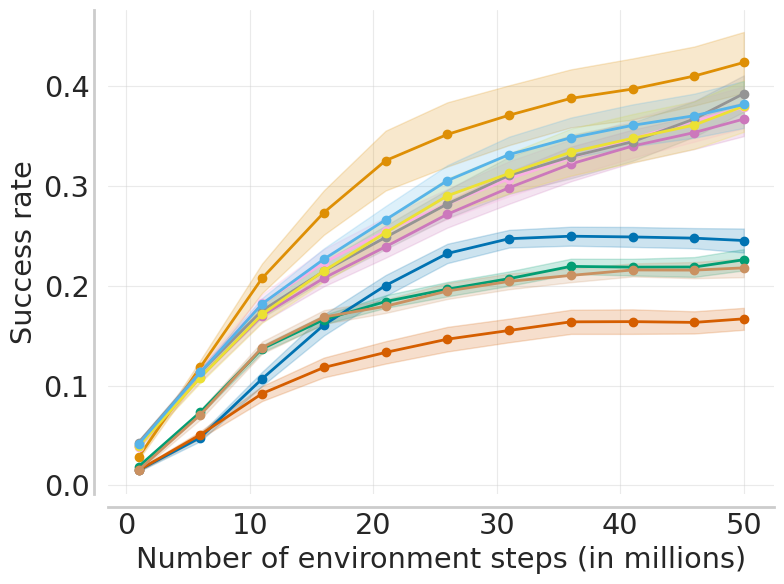

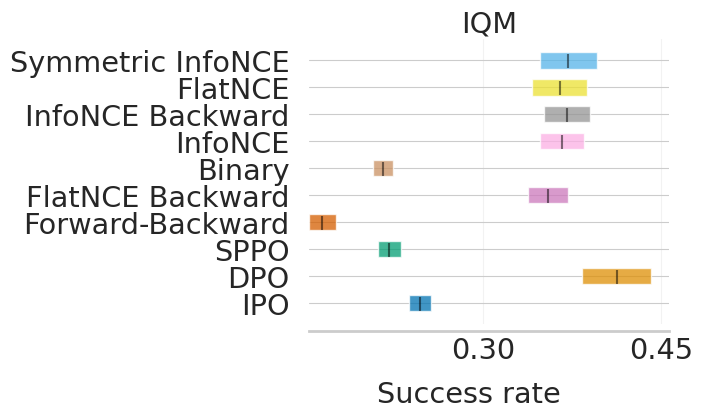

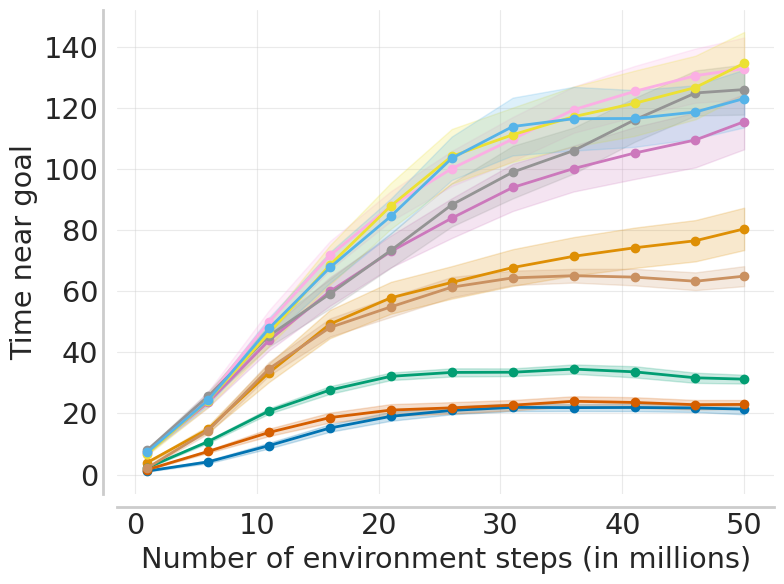

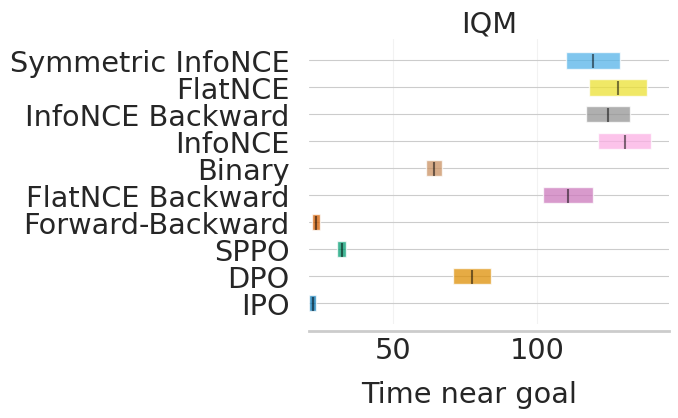

In [9]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
    )
    
    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item, window_size=window_size) 
    
    data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
    
    thresholds = np.linspace(0.0, 1, 41)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        data_flattened, thresholds
    )
    
    # Plot score distributions
    # fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    # plot_utils.plot_performance_profiles(
    #     score_distributions,
    #     thresholds,
    #     performance_profile_cis=score_distributions_cis,
    #     colors=dict(zip(list(data_flattened.keys()), sns.color_palette("colorblind"))),
    #     xlabel=rf"{metric_label} $(\tau)$",
    #     ylabel=rf"Fraction of runs with success rate > $\tau$",
    #     ax=ax,
    #     legend=False,
    #     legendsize="medium",
    #     grid_alpha=0.4, 
    #     figsize=(12,8),
    #     # use_non_linear_scaling=True
    # )
    # plt.xlim((0, 0.7))
    # plt.tight_layout()
    # plt.ylabel(rf"Fraction of runs with success rate > $\tau$", wrap=True)
    # plt.savefig(os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_performance_profile_{single_env if single_env else 'all'}.pdf"), bbox_inches="tight")
    
    
    # Sample efficiency curve
    frames = np.arange(0, 55, 5)
    frames[-1] -= 1
    ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score in data.items()}
    iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])])
    iqm_scores, iqm_cis = rly.get_interval_estimates(ale_frames_scores_dict, iqm, reps=2000)
    
    # Change to se
    if use_se:
        for key, elem in iqm_scores.items():
            se = np.apply_along_axis(lambda x: x[1]-x[0], axis=0, arr=iqm_cis[key])/2/1.96 
            iqm_cis[key] = np.concatenate(((elem-se)[None, :], (elem+se)[None,:]), axis=0)
    
    plot_utils.plot_sample_efficiency_curve(
        frames + 1,
        iqm_scores,
        iqm_cis,
        algorithms=list(data.keys()),
        xlabel=r"Number of environment steps (in millions)",
        ylabel=metric_label,
        legend=False,
        grid_alpha=0.4,
        figsize=(8, 6),
    )
    plt.title(f"{env_title_mapping[single_env] if single_env else ''}", fontsize="xx-large")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_{single_env if single_env else 'all'}.pdf"))
    
    
    # Interval estimate
    aggregate_func = lambda x: np.array(
    [
        metrics.aggregate_iqm(x),
    ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        data_flattened, aggregate_func, reps=500
    )
    
    # Change to se
    if use_se:
        for key, elem in aggregate_scores.items():
            se = (aggregate_score_cis[key][1]-aggregate_score_cis[key][0])/2/1.96 
            aggregate_score_cis[key] = np.concatenate(((elem-se)[None, :], (elem+se)[None,:]), axis=0)

    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=["IQM"],
        algorithms=list(data.keys()),
        xlabel=f"{metric_label}",
        grid_alpha=0.4,
        max_ticks=3,
        subfigure_width=4,
        xlabel_y_coordinate=-0.1,
    )
    plt.subplots_adjust(wspace=0.2, left=0.0)
    
    plt.savefig(
        os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_all_interval_estimate.pdf"), bbox_inches="tight"
    )